# PM10 and Weather data gathering (All BE stations - BE: 79)

### Plain txt file to dataframe

Background-rural both for Ozone (O3 - Max daily 8-hour mean *max8h* ozone concentrations) is being read from disk as a CSV file (Older database: https://www.eea.europa.eu/data-and-maps/data/airbase-the-european-air-quality-database-8) for the stations in Belgium: "BExxxxx0001xxx"

In [1]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import timedelta
from numpy import genfromtxt

dirpath = "AirBase_BE_v8/PM10Belgium"
fnames = listdir(dirpath)  # Read all files in directory
stationLabels = ['PM10_'] * len(fnames)  # Suffix for Ozone label
for i in range(len(fnames)):
    stationLabels[i] += fnames[i][:7]  # Add the first area code name


In [3]:
# Read last data, 2013-2019
ts_last = pd.read_pickle("../../EAAAData/BE_AQeReporting_2013-2018/PM10/ts_daymean.pkl")

# No timezoneinfo
ts_last = ts_last.tz_convert(None)

# Normalized datetime index, removing the hour
ts_last.index = ts_last.index.normalize()

for column in ts_last.columns:
    if column != "PM10":
        if column not in stationLabels:
            stationLabels.append(column)

# TODO: add -1 lag
# previous_columns = ts_last.columns
# for column in previous_columns:
#     print("column", column)
#     ts_last[column + "-1"] = ts_last[column].shift()

ts_last.tail()

,PM10,PM10_BETN035,PM10_BETR740,PM10_BETR710,PM10_BETR020,PM10_BETB011,PM10_BETR834,PM10_BELRL01,PM10_BETR223,PM10_BETR501,...,PM10_BETR811,PM10_BELGK06,PM10_BELAL01,PM10_BETM204,PM10_BETN052,PM10_BETR803,PM10_BETR817,PM10_BETR805,PM10_BELRB01,PM10_BETR823
2019-01-21,NaN,37.970833,44.275000,44.325000,41.012500,29.578947,37.741667,43.137500,32.104500,28.667000,...,47.241667,43.408333,44.533333,28.375333,45.887500,NaN,NaN,NaN,NaN,NaN
2019-01-22,NaN,41.970833,35.941667,36.491667,39.158333,27.369565,35.700000,32.137500,31.687833,26.911565,...,40.491667,42.262500,40.054167,30.021167,34.387500,NaN,NaN,NaN,NaN,NaN
2019-01-23,NaN,48.495455,53.483333,53.137500,48.366667,36.979167,44.220833,48.220833,41.979500,36.833667,...,48.950000,50.908333,47.345833,37.854500,51.970833,NaN,NaN,NaN,NaN,NaN
2019-01-24,NaN,36.616667,47.462500,48.845833,40.095833,29.895833,38.970833,43.804167,22.854500,22.250333,...,47.116667,37.533333,45.825000,19.021167,43.554167,NaN,NaN,NaN,NaN,NaN
2019-01-25,NaN,23.271429,24.207692,23.000000,23.366667,12.733333,23.066667,17.914286,12.399143,12.434857,...,27.735714,24.623077,25.000000,5.577714,21.128571,NaN,NaN,NaN,NaN,NaN


In [4]:
columnLabels = ['PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4',  # Attach all the ECMWF weather labels
                 'SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH',
                 'TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T',
                 'RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR']
columnLabels = stationLabels + columnLabels  # Join lists
for i in range(len(fnames)):
    columnLabels.append(stationLabels[i] + "-1")  # Append the lag-1 day values

In [5]:
ts_last["PM10_BETR740"].tail()

2019-01-21    44.275000
2019-01-22    35.941667
2019-01-23    53.483333
2019-01-24    47.462500
2019-01-25    24.207692
Freq: D, Name: PM10_BETR740, dtype: float64

In [6]:
for stationLabel in stationLabels:
    if stationLabel.startswith("PM10_BETN"):
        print(stationLabel)

PM10_BETN043
PM10_BETN045
PM10_BETN052
PM10_BETN054
PM10_BETN060
PM10_BETN063
PM10_BETN066
PM10_BETN067
PM10_BETN070
PM10_BETN073
PM10_BETN085
PM10_BETN093
PM10_BETN100
PM10_BETN113
PM10_BETN121
PM10_BETN132
PM10_BETN035
PM10_BETN016
PM10_BETN012
PM10_BETN029


In [7]:
# 1 loop to instantiate minDate & maxDate
for i in range(0, 1):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))
    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])
    currentMinDate = min(df1['month'])
    currentMaxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st   
minDate = currentMinDate
maxDate = currentMaxDate

# Now, do search all files for minDate, MaxDate
for i in range(0, len(fnames)):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))

    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])

    currentMinDate = min(df1['month'])
    currentMaxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st
    
    if currentMinDate < minDate:
        minDate = currentMinDate
    if currentMaxDate > maxDate:
        maxDate = currentMaxDate       
        
# Finally, to check the last data        
minDate2013_2018 = ts_last.index.min()
maxDate2013_2018 = ts_last.index.max()
if minDate2013_2018 < minDate:
    minDate = minDate2013_2018
if maxDate2013_2018 > maxDate:
    maxDate = maxDate2013_2018     

print ("Min date: {}, Max Date: {}".format(minDate, maxDate))
ts = pd.DataFrame(np.nan, index=pd.date_range(start=minDate, end=maxDate, freq='D'), columns=columnLabels)

# Normalized datetime index, removing the hour
ts.index = ts.index.normalize()

Min date: 1995-01-01 00:00:00, Max Date: 2019-01-25 00:00:00


In [8]:
df1.head()

,month,1,validity1,2,validity2,3,validity3,4,validity4,5,...,27,validity27,28,validity28,29,validity29,30,validity30,31,validity31
0,2001-01-01,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,...,22.0,1,36.0,1,52.0,1,45.0,1,52.0,1
1,2001-02-01,74.0,1,27.0,1,18.0,1,13.0,1,17.0,...,32.0,1,25.0,1,0.0,0,0.0,0,0.0,0
2,2001-03-01,38.0,1,46.0,1,54.0,1,53.0,1,50.0,...,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0
3,2001-04-01,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,...,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,0.0,0
4,2001-05-01,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,...,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0


In [9]:
for i in range(0, len(fnames)):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))

    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])

    minDate = min(df1['month'])
    maxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st

    for row in df1.itertuples(index=True, name='df1'): # Foreach month
        date = row[1]
        for columnIndex in range(1, df1.shape[1]): # Foreach day
            if columnIndex % 2 == 0: # Even column
                if row[columnIndex + 1] == 1: # If sensor reading valid
                    currentDate = date + timedelta(days=((columnIndex - 2) / 2)) # Get year-month-day
                    try:
                        ts.at[currentDate, dfColumn] = row[columnIndex] # Set value to time-series
                    except AttributeError as error:
                        print("fname: ", fname)
                        print("Error: ", error)
                        break

columnLabels               

['PM10_BE0312A',
 'PM10_BEGRT01',
 'PM10_BELAB01',
 'PM10_BELAB02',
 'PM10_BELAL01',
 'PM10_BELAL02',
 'PM10_BELAL05',
 'PM10_BELGK06',
 'PM10_BELGK09',
 'PM10_BELHB23',
 'PM10_BELHR01',
 'PM10_BELKO01',
 'PM10_BELML01',
 'PM10_BELMN01',
 'PM10_BELOB01',
 'PM10_BELOB02',
 'PM10_BELRL01',
 'PM10_BELSA04',
 'PM10_BELSZ02',
 'PM10_BELTR01',
 'PM10_BELWZ01',
 'PM10_BELZD01',
 'PM10_BETAND3',
 'PM10_BETB011',
 'PM10_BETH201',
 'PM10_BETM204',
 'PM10_BETM705',
 'PM10_BETM802',
 'PM10_BETMEU1',
 'PM10_BETN043',
 'PM10_BETN045',
 'PM10_BETN052',
 'PM10_BETN054',
 'PM10_BETN060',
 'PM10_BETN063',
 'PM10_BETN066',
 'PM10_BETN067',
 'PM10_BETN070',
 'PM10_BETN073',
 'PM10_BETN085',
 'PM10_BETN093',
 'PM10_BETN100',
 'PM10_BETN113',
 'PM10_BETN121',
 'PM10_BETN132',
 'PM10_BETR001',
 'PM10_BETR012',
 'PM10_BETR020',
 'PM10_BETR201',
 'PM10_BETR221',
 'PM10_BETR222',
 'PM10_BETR223',
 'PM10_BETR240',
 'PM10_BETR501',
 'PM10_BETR502',
 'PM10_BETR510',
 'PM10_BETR511',
 'PM10_BETR512',
 'PM10_BETR701

In [16]:
print("Station count: ", len(stationLabels))

Station count:  83


In [17]:
stationLabels

['PM10_BE0312A',
 'PM10_BEGRT01',
 'PM10_BELAB01',
 'PM10_BELAB02',
 'PM10_BELAL01',
 'PM10_BELAL02',
 'PM10_BELAL05',
 'PM10_BELGK06',
 'PM10_BELGK09',
 'PM10_BELHB23',
 'PM10_BELHR01',
 'PM10_BELKO01',
 'PM10_BELML01',
 'PM10_BELMN01',
 'PM10_BELOB01',
 'PM10_BELOB02',
 'PM10_BELRL01',
 'PM10_BELSA04',
 'PM10_BELSZ02',
 'PM10_BELTR01',
 'PM10_BELWZ01',
 'PM10_BELZD01',
 'PM10_BETAND3',
 'PM10_BETB011',
 'PM10_BETH201',
 'PM10_BETM204',
 'PM10_BETM705',
 'PM10_BETM802',
 'PM10_BETMEU1',
 'PM10_BETN043',
 'PM10_BETN045',
 'PM10_BETN052',
 'PM10_BETN054',
 'PM10_BETN060',
 'PM10_BETN063',
 'PM10_BETN066',
 'PM10_BETN067',
 'PM10_BETN070',
 'PM10_BETN073',
 'PM10_BETN085',
 'PM10_BETN093',
 'PM10_BETN100',
 'PM10_BETN113',
 'PM10_BETN121',
 'PM10_BETN132',
 'PM10_BETR001',
 'PM10_BETR012',
 'PM10_BETR020',
 'PM10_BETR201',
 'PM10_BETR221',
 'PM10_BETR222',
 'PM10_BETR223',
 'PM10_BETR240',
 'PM10_BETR501',
 'PM10_BETR502',
 'PM10_BETR510',
 'PM10_BETR511',
 'PM10_BETR512',
 'PM10_BETR701

In [12]:
ts_bak = ts
ts_last_bak = ts_last

In [13]:
ts = ts_bak
ts_last = ts_last_bak

In [18]:
#ts = ts.append(ts_last, sort=True)# TODO: test merge
# ts = pd.concat([ts, ts_last], ignore_index=False, sort=True)
#ts = ts.merge(ts_last, how="right", validate="one_to_one")
#ts = ts.merge(ts_last, how="right")
#ts = ts.merge(ts_last, how="outer", validate="one_to_many")
#ts = ts.merge(ts_last, how="outer", sort=True)
# ts = ts.update(ts_last)
# ts = pd.merge_ordered(ts, ts_last)
#ts = ts.combine_first(ts_last)
#ts = ts_last.combine_first(ts)
#ts = ts.update(ts_last)
#ts = pd.concat(ts, ts_last, axis=1, join_axes=[ts.index])

ts.columns

Index(['PM10_BE0312A', 'PM10_BEGRT01', 'PM10_BELAB01', 'PM10_BELAB02',
       'PM10_BELAL01', 'PM10_BELAL02', 'PM10_BELAL05', 'PM10_BELGK06',
       'PM10_BELGK09', 'PM10_BELHB23',
       ...
       'PM10_BETR801-1', 'PM10_BETR802-1', 'PM10_BETR811-1', 'PM10_BETR815-1',
       'PM10_BETR831-1', 'PM10_BETR832-1', 'PM10_BETR833-1', 'PM10_BETR834-1',
       'PM10_BETR841-1', 'PM10_BETWOL1-1'],
      dtype='object', length=207)

In [19]:
ts_last.columns

Index(['PM10', 'PM10_BETN035', 'PM10_BETR740', 'PM10_BETR710', 'PM10_BETR020',
       'PM10_BETB011', 'PM10_BETR834', 'PM10_BELRL01', 'PM10_BETR223',
       'PM10_BETR501', 'PM10_BETR815', 'PM10_BETR221', 'PM10_BETN043',
       'PM10_BELSZ02', 'PM10_BETN121', 'PM10_BETM802', 'PM10_BETR502',
       'PM10_BETR510', 'PM10_BELAB02', 'PM10_BETN067', 'PM10_BETM705',
       'PM10_BETN093', 'PM10_BETN045', 'PM10_BETR750', 'PM10_BETR802',
       'PM10_BELAL02', 'PM10_BETR511', 'PM10_BETMEU1', 'PM10_BETR702',
       'PM10_BETR512', 'PM10_BETN073', 'PM10_BETN054', 'PM10_BETR012',
       'PM10_BETWOL1', 'PM10_BETR731', 'PM10_BELOB02', 'PM10_BETN132',
       'PM10_BETR001', 'PM10_BETR701', 'PM10_BELAL05', 'PM10_BETR240',
       'PM10_BETN085', 'PM10_BETN070', 'PM10_BETN100', 'PM10_BETH201',
       'PM10_BETR222', 'PM10_BETN113', 'PM10_BETR831', 'PM10_BELMN01',
       'PM10_BELHB23', 'PM10_BETN016', 'PM10_BELSA04', 'PM10_BETN012',
       'PM10_BETN060', 'PM10_BETN063', 'PM10_BELOB01', 'PM10_BETN029'

In [20]:
# Normalized datetime index, removing the hour
# ts.index = ts.index.normalize()
# ts_last.index = ts_last.index.normalize()

# TODO: create missing columns
for column in ts_last.columns:
    if column != "PM10":
#         print("column:", column)
        if column not in ts.columns:
            print("column:", column)
            print("Added column:", column)
            ts[column] = np.nan

In [21]:
lst1 = list(ts.columns)
lst2 = list(ts_last.columns)

# Copy values
for row in ts_last.itertuples(index=True, name='ts_last'): # Foreach month
    date = row[0]
    for i in range(len(row) - 1):
        column = lst2[i]
        if column != "PM10" and "PM10_" in column:
#             print("column", column)
#             print(date)
#             print("lst1.index(column)", lst1.index(column) + 1)
#             print("lst2.index(column)", lst2.index(column) + 1)
#             print("row[lst2.index(column)]", row[lst2.index(column) + 1])
#             ts.at[date, lst1.index(column) + 1] = row[lst2.index(column) + 1]
            value = row[lst2.index(column)]
            if value != np.nan and value != None:
                ts.at[date, column] = value
            #ts.at[row[0], 'O3_' + row[stationNameIndex]] = row[valueIndex] # Set value to time-series

In [22]:
lst1.index('PM10_BE0312A')
#ts['PM10_BE0312A'] = np.nan

0

In [23]:
lst1[0]

'PM10_BE0312A'

In [24]:
ts.columns[0]

'PM10_BE0312A'

In [25]:
ts["PM10_BETR702"]["2016-9-2"]

9.3125

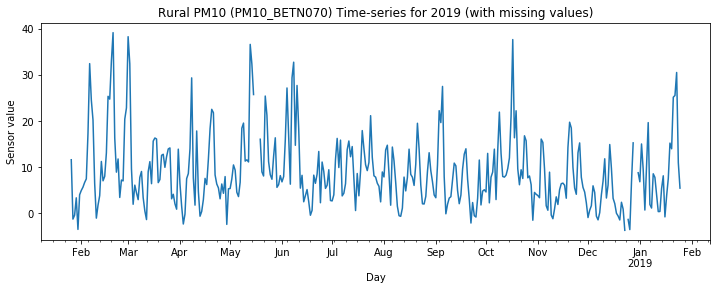

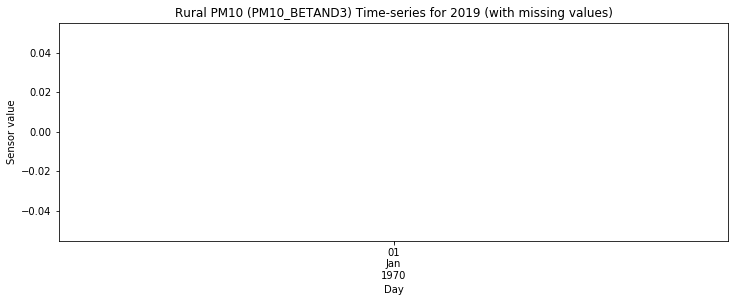

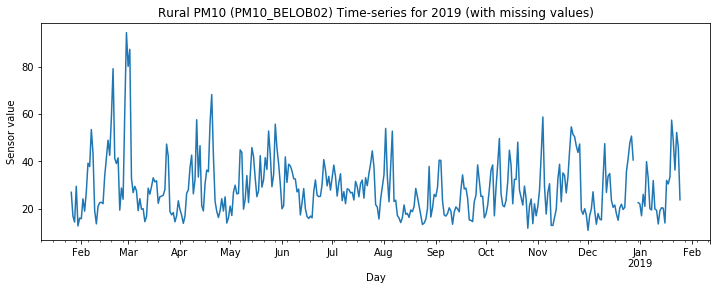

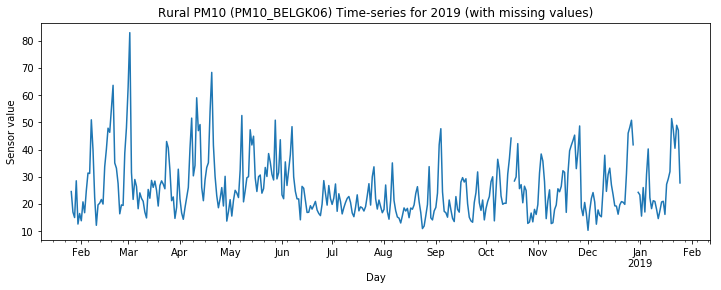

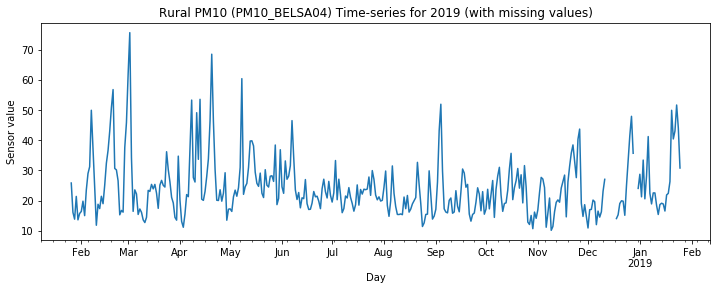

In [26]:
# Test plot stations
stationsToCheck = ['PM10_BETN070', 'PM10_BETAND3', 'PM10_BELOB02', 'PM10_BELGK06','PM10_BELSA04']
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2019 (with missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);

### On missing values get the reading from the closest station

Get the correlation between different stations (columns):

In [27]:
import math
from collections import OrderedDict

def getCorrelation(station1, station2):
    return ts[station1].corr(ts[station2])

correlationStationToStation = {}

for station1 in ts.columns:
    if "PM10_" in station1 and "-1" not in station1:
        correlationsToStation = {}
        for station2 in ts.columns:
            if station1 != station2 and "PM10_" in station2 and "-1" not in station2: 
                correlation = getCorrelation(station1, station2)  
                if correlation != None and not np.isnan(correlation):
                    correlationsToStation[station2] = correlation
        correlationStationToStation[station1] = OrderedDict(sorted(correlationsToStation.items(), reverse=True, key=lambda t: t[1]))

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [28]:
correlationStationToStation["PM10_BELOB02"].keys()

odict_keys(['PM10_BETR823', 'PM10_BETR817', 'PM10_BETR805', 'PM10_BELRB01', 'PM10_BETR803', 'PM10_BETR020', 'PM10_BETR833', 'PM10_BELRL01', 'PM10_BETN016', 'PM10_BELGK06', 'PM10_BETR512', 'PM10_BETR811', 'PM10_BETR223', 'PM10_BETR221', 'PM10_BETR710', 'PM10_BELAL02', 'PM10_BETN093', 'PM10_BETN029', 'PM10_BETM204', 'PM10_BETN012', 'PM10_BETN132', 'PM10_BETR502', 'PM10_BETB011', 'PM10_BETN060', 'PM10_BETR801', 'PM10_BETR834', 'PM10_BELMN01', 'PM10_BETR802', 'PM10_BETR841', 'PM10_BETR701', 'PM10_BELSA04', 'PM10_BETR740', 'PM10_BETR702', 'PM10_BETN067', 'PM10_BELAL01', 'PM10_BELSZ02', 'PM10_BELHB23', 'PM10_BETR731', 'PM10_BETWOL1', 'PM10_BETR750', 'PM10_BETN063', 'PM10_BETR012', 'PM10_BELAB02', 'PM10_BETR240', 'PM10_BETR815', 'PM10_BETR510', 'PM10_BETN054', 'PM10_BETN100', 'PM10_BETR501', 'PM10_BETN113', 'PM10_BETR511', 'PM10_BETR222', 'PM10_BETN052', 'PM10_BETMEU1', 'PM10_BELOB01', 'PM10_BETN073', 'PM10_BETN043', 'PM10_BETN121', 'PM10_BELAB01', 'PM10_BETN085', 'PM10_BETN045', 'PM10_BELAL0

In [29]:
getCorrelation("PM10_BELOB02", "PM10_BETR710")

0.8742881983146786

In [30]:
correlationStationToStation["PM10_BETN073"].keys()

odict_keys(['PM10_BELWZ01', 'PM10_BELGK09', 'PM10_BETR510', 'PM10_BETR501', 'PM10_BETR511', 'PM10_BELML01', 'PM10_BETN067', 'PM10_BETR201', 'PM10_BETN063', 'PM10_BETB011', 'PM10_BETN054', 'PM10_BEGRT01', 'PM10_BELAL01', 'PM10_BETR221', 'PM10_BETR502', 'PM10_BETR832', 'PM10_BETR222', 'PM10_BETM204', 'PM10_BELSZ02', 'PM10_BETN100', 'PM10_BETR012', 'PM10_BELGK06', 'PM10_BELAB01', 'PM10_BELAB02', 'PM10_BETR823', 'PM10_BETN113', 'PM10_BETR815', 'PM10_BETR512', 'PM10_BETR702', 'PM10_BELRL01', 'PM10_BETR223', 'PM10_BETR817', 'PM10_BELRB01', 'PM10_BETR801', 'PM10_BETR811', 'PM10_BETR803', 'PM10_BETWOL1', 'PM10_BETR805', 'PM10_BELMN01', 'PM10_BETN045', 'PM10_BETMEU1', 'PM10_BETN052', 'PM10_BETN016', 'PM10_BETR710', 'PM10_BETR834', 'PM10_BELSA04', 'PM10_BETR020', 'PM10_BETR701', 'PM10_BELOB02', 'PM10_BETN093', 'PM10_BETR750', 'PM10_BETR841', 'PM10_BETN029', 'PM10_BETR833', 'PM10_BETN012', 'PM10_BELHB23', 'PM10_BETR731', 'PM10_BELAL02', 'PM10_BETH201', 'PM10_BETN121', 'PM10_BETR740', 'PM10_BETN13

In [31]:
correlationStationToStation["PM10_BETN073"]

OrderedDict([('PM10_BELWZ01', 0.9106295254086606),
             ('PM10_BELGK09', 0.8678323444713336),
             ('PM10_BETR510', 0.8649834787802798),
             ('PM10_BETR501', 0.838054659439997),
             ('PM10_BETR511', 0.8366747969771329),
             ('PM10_BELML01', 0.8266361040546417),
             ('PM10_BETN067', 0.8222363694167316),
             ('PM10_BETR201', 0.8221090728313274),
             ('PM10_BETN063', 0.8202175524271906),
             ('PM10_BETB011', 0.8166040711521322),
             ('PM10_BETN054', 0.8075588173913162),
             ('PM10_BEGRT01', 0.807470671416404),
             ('PM10_BELAL01', 0.806944860665837),
             ('PM10_BETR221', 0.8064523447612113),
             ('PM10_BETR502', 0.8046562991547811),
             ('PM10_BETR832', 0.8025094610830917),
             ('PM10_BETR222', 0.801023452606688),
             ('PM10_BETM204', 0.7966519555079234),
             ('PM10_BELSZ02', 0.7963289152546817),
             ('PM10_BETN100', 0.795

In [32]:
ts2 = ts.copy()
# TODO: Normalized datetime index, removing the hour
ts2.index = ts2.index.normalize()

for dataRow in ts2.itertuples(index=True, name='Pandas'):
    date = dataRow[0]
    for stationLabel in ts2.columns:       
        if "PM10_" in stationLabel and "-1" not in stationLabel:       
            try: # TODO: isnnan.any() for cells with dual values
                if np.isnan(ts2.at[date, stationLabel]):  # If no value at station
                    for closestStationLabel in correlationStationToStation[stationLabel].keys():                
                        closestValue = ts.at[date, closestStationLabel]
                        if not np.isnan(closestValue):
                            ts2.at[date, stationLabel] = closestValue
                            break  # Exit the loop    
            except (ValueError,IOError) as err:
                print("date: ", date, "stationLabel: ", stationLabel)
                print(err)
                
ts = ts2  

In [33]:
ts2["PM10_BETR702"]["2016-09-2"]

9.3125

In [34]:
ts2.head(365)["PM10_BELOB02"].head(20)

1995-01-01    19.0
1995-01-02    24.0
1995-01-03    98.0
1995-01-04    42.0
1995-01-05    45.0
1995-01-06    81.0
1995-01-07    93.0
1995-01-08    27.0
1995-01-09    56.0
1995-01-10    30.0
1995-01-11    27.0
1995-01-12    38.0
1995-01-13    69.0
1995-01-14    97.0
1995-01-15    49.0
1995-01-16    24.0
1995-01-17    26.0
1995-01-18    26.0
1995-01-19    19.0
1995-01-20    43.0
Freq: D, Name: PM10_BELOB02, dtype: float64

Get station lon/lat coordinates:

In [ ]:
# Get station coordinates
import re, collections
from lxml import etree
import xml.etree.ElementTree as ET

tree = ET.parse('BE_meta.xml')
root = tree.getroot()

stationLonLat = {}
# stationLonLat["BELOB02"] = (3.376, 50.914)  # Manually add BELOB02 40OB02 - WIELSBEKE (lon/lat was missing)
# stationLonLat["BELSA04"] = (4.4042624, 51.3135154)
# stationLonLat["BETR834"] = (4.3799862, 51.0916466)

for child in root:    
    for child1 in child:          
        if child1.tag == "station":           
            if child1.attrib['Id'].startswith("BE"):  # TODO: 
                for child2 in child1:
                    if child2.tag == "station_info":
                        lon = 0.0
                        lat = 0.0
                        for child3 in child2:         
                            if child3.tag == "station_latitude_decimal_degrees":
                                lat = child3.text
                            if child3.tag == "station_longitude_decimal_degrees":
                                lon = child3.text                        
                        stationLonLat[child1.attrib['Id'][:7]] = (float(lon), float(lat))

# Remove stations without max8h file on disk
stationsToDelete = []
for stationKey in stationLonLat.keys():
    if not "PM10_" + stationKey in stationLabels:
        stationsToDelete.append(stationKey)

for stationToDelete in stationsToDelete:
    del stationLonLat[stationToDelete]
        

Store an ordered dictionary for the next closest station of the current:

In [ ]:
import math
from collections import OrderedDict

def getDistanceDegrees(station1, station2):
    return math.sqrt((stationLonLat[station1][0] -stationLonLat[station2][0])**2 + (stationLonLat[station1][1] -stationLonLat[station2][1])**2)

distanceStationToStation = {}

for station1 in stationLonLat.keys():
    distancesToStation = {}
    for station2 in stationLonLat.keys():
        if station1 != station2:
            distancesToStation[station2] = getDistanceDegrees(station1, station2) 
    distanceStationToStation[station1] = OrderedDict(sorted(distancesToStation.items(), key=lambda t: t[1]))
    

In [ ]:
distanceStationToStation["BELOB02"].keys()

Check if distances of a specific station are indeed ordered:

In [ ]:
distanceStationToStation["BETN073"].keys()

In [ ]:
distanceStationToStation["BETN073"]

In [ ]:
ts2 = ts.copy()
for dataRow in ts2.itertuples(index=True, name='Pandas'):
    date = dataRow[0]
    for stationLabel in stationLabels:
        if np.isnan(ts2.at[date, stationLabel]):  # If no value at station
            for closestStationLabel in distanceStationToStation[stationLabel[-7:]].keys():
                closestValue = ts.at[date, "PM10_" + closestStationLabel]
                if not np.isnan(closestValue):
                    ts2.at[date, stationLabel] = closestValue
                    break  # Exit the loop    
ts = ts2                    

In [ ]:
ts2.head(365)["PM10_BELOB02"].head(20)

Check if missing values indeed filled:

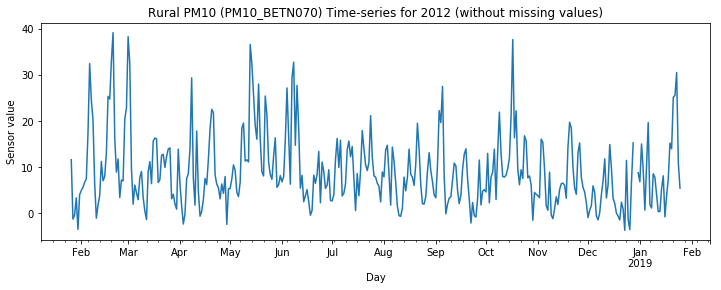

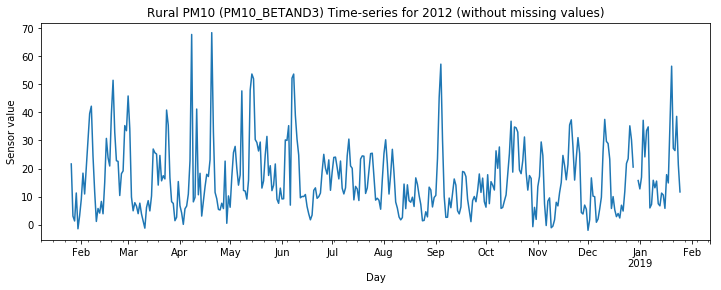

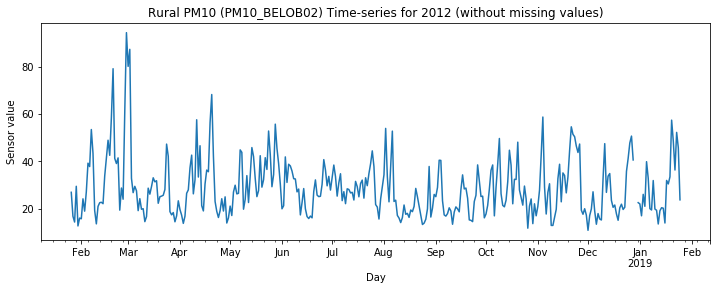

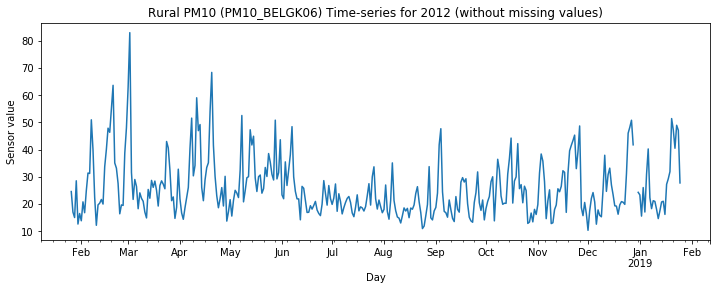

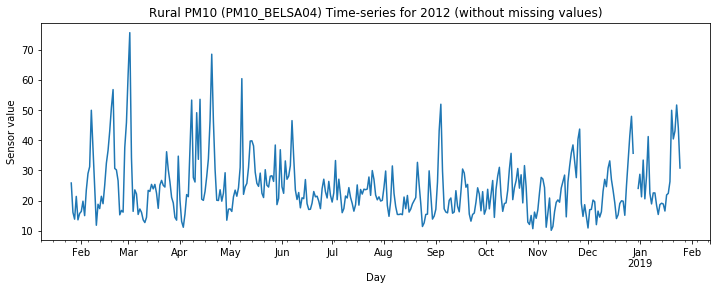

In [35]:
# Test plot stations
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2012 (without missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);

Adding weather data into the dataframe:

In [36]:
# Read geo-weather data
weatherData = genfromtxt('ECMWF\BETN073_51vars_19900101To20171231.csv', delimiter=',')

columns = len(weatherData[0])
row = -1
column = -1
addedColumns = len(stationLabels)

# Attach weather data
for dataRow in ts.itertuples(index=True, name='Pandas'):    
    date = dataRow[0]
    row += 1       
    if row < weatherData.shape[0] and column < weatherData.shape[1]:
        for column in range(columns):  
            ts.at[date, columnLabels[column + addedColumns]] = weatherData[row][column] # Set value to time-series        

Add 1-day lags:

In [ ]:
# columns = len(weatherData[0])
row = -1
column = -1
# addedColumns = len(stationLabels)
PM10lags = [0] * addedColumns

# Attach weather data
for dataRow in ts.itertuples(index=True, name='Pandas'):    
    date = dataRow[0]
    for i in range(len(stationLabels)):
        ts.at[date, stationLabels[i] + '-1'] = PM10lags[i] # Get lag value
        PM10lags[i] = ts.at[date, stationLabels[i]]  # Set next lag value

In [37]:
# TODO: add -1 lag
previous_columns = ts.columns
for column in previous_columns:
    if "PM10_" in column and "-1" not in column:
        ts[column + "-1"] = ts[column].shift()

In [38]:
ts.head(6000).tail(5)["PM10_BETN073"]

2011-06-01    15.071
2011-06-02    13.008
2011-06-03    18.758
2011-06-04    21.404
2011-06-05    21.862
Freq: D, Name: PM10_BETN073, dtype: float64

In [43]:
ts.head(6000).tail(5)["PM10_BETN073-1"]

2011-06-01    13.550
2011-06-02    15.071
2011-06-03    13.008
2011-06-04    18.758
2011-06-05    21.404
Freq: D, Name: PM10_BETN073-1, dtype: float64

In [40]:
ts.head(6000).tail(5)["PARCS"]

2011-06-01    2990379.0
2011-06-02    2987812.0
2011-06-03    2989369.0
2011-06-04    2993987.0
2011-06-05    3002104.0
Freq: D, Name: PARCS, dtype: float64

In [41]:
ts.head(6000).tail(5)["FSR"]

2011-06-01    0.146394
2011-06-02    0.146390
2011-06-03    0.146392
2011-06-04    0.146391
2011-06-05    0.146393
Freq: D, Name: FSR, dtype: float64

Time-series plot of O3, first 365 days (1990, with missing data):

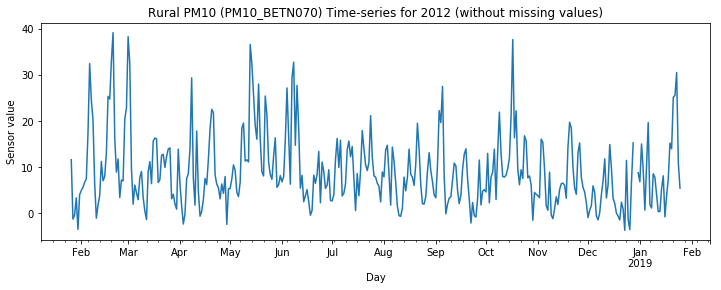

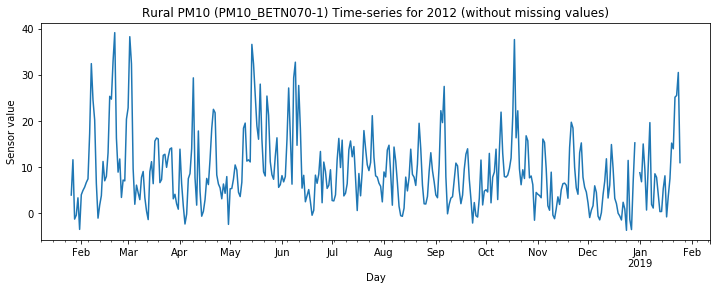

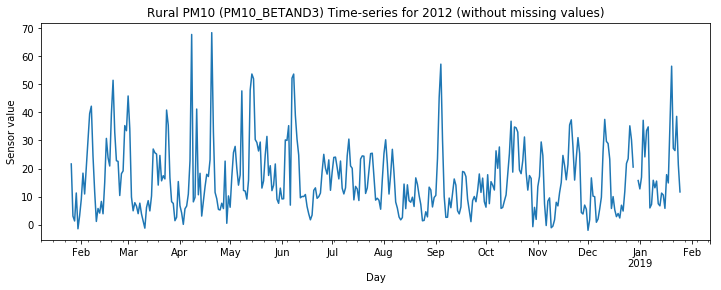

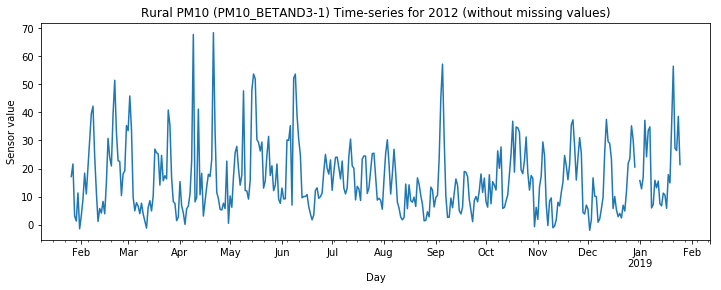

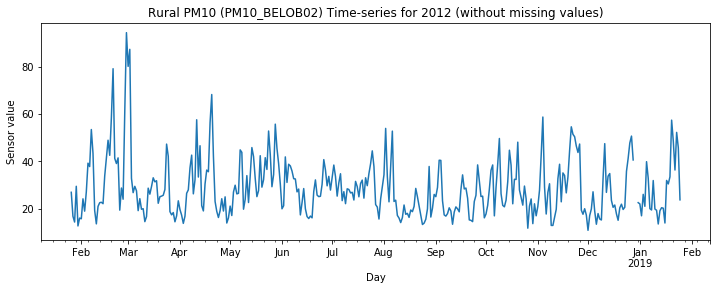

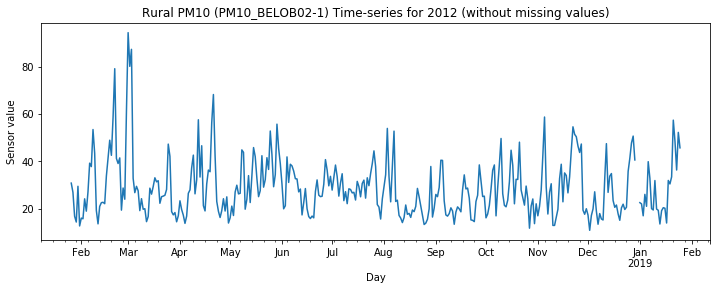

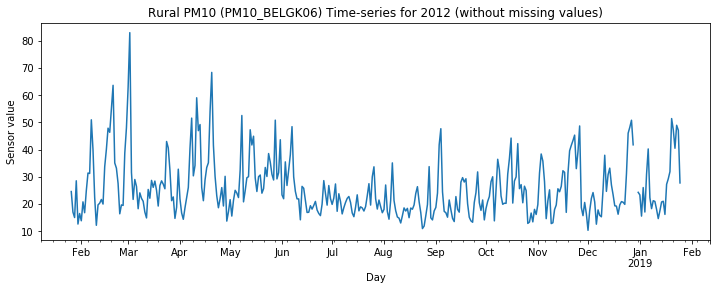

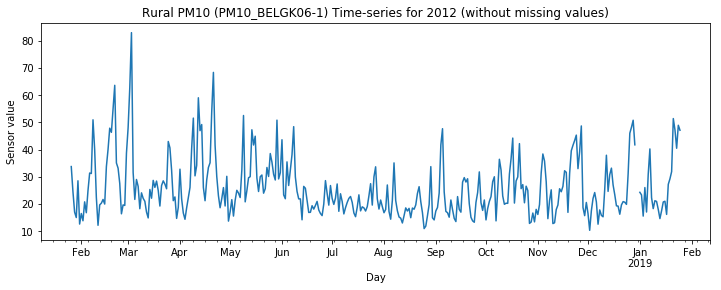

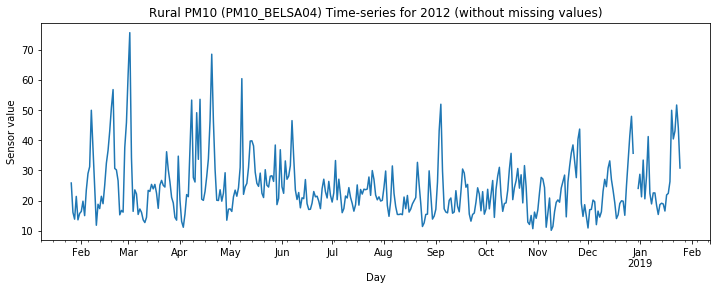

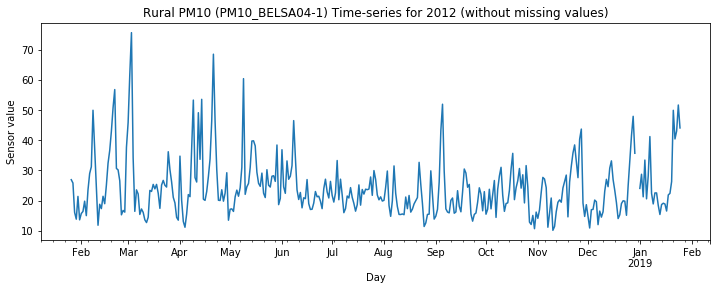

In [42]:
# Test plot stations and lags
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2012 (without missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);
    
    stationToCheckLag = stationToCheck + "-1"
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2012 (without missing values)'.format(stationToCheckLag))
    ax.grid(True)
    ts.tail(365)[stationToCheckLag].plot(ax = ax);

Plot other time-series variables (Temperature 2m):

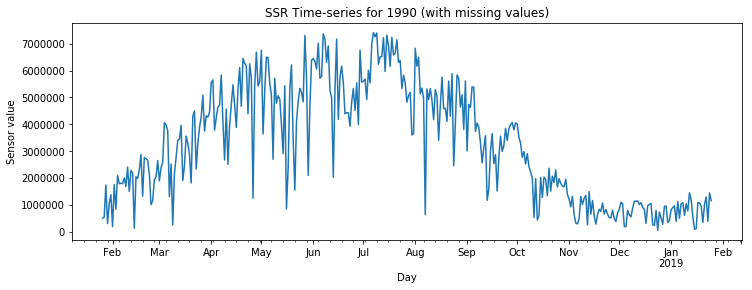

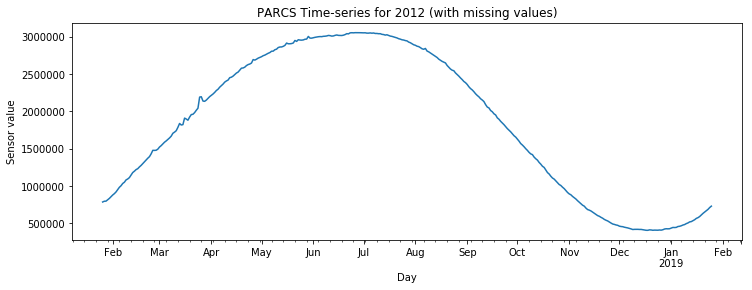

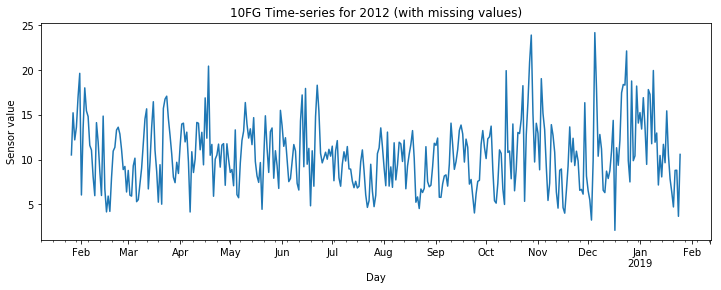

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('SSR Time-series for 1990 (with missing values)')
ax.grid(True)
# ts.tail(365)['2T'].plot(ax = ax);
# ['O3', '10FG', 'BLH', '10U', '2T', 'SSR', 'SUND', 'O3-1']
#['O3','PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4','SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH','TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T','RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR','O3-1']
ts.tail(365)['SSR'].plot(ax = ax);

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('PARCS Time-series for 2012 (with missing values)')
ax.grid(True)
ts.tail(365)['PARCS'].plot(ax = ax);

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('10FG Time-series for 2012 (with missing values)')
ax.grid(True)
ts.tail(365)['10FG'].plot(ax = ax);

Lag variable (-1 day):

In [45]:
ts.tail(10)[stationLabels[0]]  

2019-01-16     0.917000
2019-01-17    16.083667
2019-01-18     8.708667
2019-01-19    24.375333
2019-01-20    28.687833
2019-01-21    22.542000
2019-01-22    27.812833
2019-01-23    40.521167
2019-01-24    17.292000
2019-01-25     3.256286
Freq: D, Name: PM10_BE0312A, dtype: float64

In [46]:
ts.tail(10)[stationLabels[0] + '-1']

2019-01-16     7.911565
2019-01-17     0.917000
2019-01-18    16.083667
2019-01-19     8.708667
2019-01-20    24.375333
2019-01-21    28.687833
2019-01-22    22.542000
2019-01-23    27.812833
2019-01-24    40.521167
2019-01-25    17.292000
Freq: D, Name: PM10_BE0312A-1, dtype: float64

In [47]:
ts.tail(10)[stationLabels[1]]

2019-01-16    12.652174
2019-01-17    27.770833
2019-01-18    24.229167
2019-01-19    29.708333
2019-01-20    68.729167
2019-01-21    34.625000
2019-01-22    31.020833
2019-01-23    44.979167
2019-01-24    36.145833
2019-01-25    23.000000
Freq: D, Name: PM10_BEGRT01, dtype: float64

In [48]:
ts.tail(10)[stationLabels[1] + '-1']

2019-01-16    22.375000
2019-01-17    12.652174
2019-01-18    27.770833
2019-01-19    24.229167
2019-01-20    29.708333
2019-01-21    68.729167
2019-01-22    34.625000
2019-01-23    31.020833
2019-01-24    44.979167
2019-01-25    36.145833
Freq: D, Name: PM10_BEGRT01-1, dtype: float64

In [49]:
ts.tail(10)[stationLabels[2]]

2019-01-16    16.387500
2019-01-17    31.881818
2019-01-18    34.679167
2019-01-19    37.762500
2019-01-20    63.111765
2019-01-21    48.512500
2019-01-22    42.908333
2019-01-23    56.283333
2019-01-24    49.991667
2019-01-25    28.664286
Freq: D, Name: PM10_BELAB01, dtype: float64

In [50]:
ts.tail(10)[stationLabels[2] + '-1']

2019-01-16    24.366667
2019-01-17    16.387500
2019-01-18    31.881818
2019-01-19    34.679167
2019-01-20    37.762500
2019-01-21    63.111765
2019-01-22    48.512500
2019-01-23    42.908333
2019-01-24    56.283333
2019-01-25    49.991667
Freq: D, Name: PM10_BELAB01-1, dtype: float64

In [51]:
ts.tail(10)[stationLabels[3]]

2019-01-16     4.250333
2019-01-17    20.542000
2019-01-18    16.271167
2019-01-19    29.312833
2019-01-20    76.875333
2019-01-21    27.604500
2019-01-22    25.694174
2019-01-23    35.354500
2019-01-24    20.812833
2019-01-25     9.208667
Freq: D, Name: PM10_BELAB02, dtype: float64

In [52]:
ts.tail(10)[stationLabels[3] + '-1']

2019-01-16     8.958667
2019-01-17     4.250333
2019-01-18    20.542000
2019-01-19    16.271167
2019-01-20    29.312833
2019-01-21    76.875333
2019-01-22    27.604500
2019-01-23    25.694174
2019-01-24    35.354500
2019-01-25    20.812833
Freq: D, Name: PM10_BELAB02-1, dtype: float64

In [53]:
ts.isna().sum().sum()

20616

Not useful interpolations: Cubic and Spline (order 2-5+) seem to have very high leverage, skewing the original data:

Useful interpolations: 'from_derivatives' (piecewise polynomial interpolation) and linear. (Probably) the most interesting interpolation: PCHIP 1-d monotonic cubic interpolation (see:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator). Compared to the plain cubic interpolation, doesn't seem to skew the original data points. Pchip looks similar to the linear interpolation, with some extra smoothing.

In [ ]:
ts2a = ts.interpolate(method='linear',limit=20,limit_direction='both')
ts2b = ts.interpolate(method='from_derivatives',limit=20,limit_direction='both')
ts2c = ts.interpolate(method='pchip',limit=20,limit_direction='both')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
ax[0].set_ylabel('Sensor value')
ax[0].set_xlabel('Day')
ax[0].set_title('PM10 Time-series for 1990 (linear interpolation)')
ax[1].set_title('PM10 Time-series for 1990 (piecewise polynomial interpolation)')
ax[2].set_title('PM10 Time-series for 1990 (pchip: 1-d monotonic cubic interpolation)')
ts2a.head(365)['PM10_BETN054'].plot(ax = ax[0]);
ts2b.head(365)['PM10_BETN054'].plot(ax = ax[1]);
ts2c.head(365)['PM10_BETN054'].plot(ax = ax[2]);

In [54]:
ts_interpolated = ts.interpolate(method='linear',limit=7,limit_direction='both')  # 8 days
ts_interpolated.head(10)['PM10_BETN066']

1995-01-01    19.0
1995-01-02    24.0
1995-01-03    98.0
1995-01-04    42.0
1995-01-05    45.0
1995-01-06    81.0
1995-01-07    93.0
1995-01-08    27.0
1995-01-09    56.0
1995-01-10    30.0
Freq: D, Name: PM10_BETN066, dtype: float64

In [ ]:
ts_interpolated.head(30)['PM10_BETN054-1']

In [ ]:
ts_interpolated.head(30)['PM10_BETN054']

In [55]:
print("Count of NaN values: ", np.isnan(ts_interpolated).any().sum())

Count of NaN values:  166


In [56]:
print("Count of zero values: ", ts_interpolated.size - np.count_nonzero(ts_interpolated))

Count of zero values:  60259


In [57]:
len(ts.columns)

217

In [58]:
# Store to time-series csv
file_name = "ALL_BE_51vars_PM10_PM10-1_19940101To20190125.csv"
ts_interpolated.to_csv(file_name, sep=',', encoding='utf-8')